This notebook is for generating trajectory data to feed into the interpolation

Glider track: "survey" is a function of lat, lon, time, depth

Here let's make our survey in the Southern Ocean so we can sample the "ACC_SMST" data acquired using the Pre-SWOT_Numerical_Sumulation_Demo notebook. Lon is from 150 to 154, lat is from -57 to -53

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from math import radians, degrees, sin, cos, asin, acos, sqrt

# great circle distance (from Jake Steinberg)
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)))


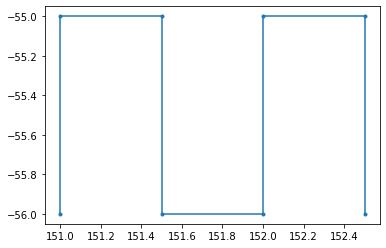

In [2]:
# --------- define sampling: change the values in this section -------
# 3-D sampling: glider or ship-towed underway CTD
# define x & y waypoints and z range
# x & y must have the same size
xwaypoints = [151, 151, 151.5, 151.5, 152, 152, 152.5, 152.5]
ywaypoints = [-56, -55,   -55,   -56, -56, -55, -55, -56] 
zrange = [5, 500] # depth range of profiles 
hspeed = 5 # platform horizontal speed in m/s
vspeed = 1 # platform vertical (profile) speed in m/s * note, may want different up/down speeds 
plt.plot(xwaypoints, ywaypoints,'.-')

In [3]:
# time resolution of sampling (dt):
# 1) could use the model timestep (e.g., 1 hour)
# 2) could use the time of one round-trip vertical profile (could smaller than the model timestep). In this case, we would have to interpolate in lat/lon and depth separetely. 
# 3) could use the time between vertical measurements, since that's ultimately how we want to sample the model in the vertical- but this will make a HUGE set of points to interpolate to, which may be very slow/expensive.

# Here, use method 1/2: the smaller of 1 hour and the roundtrip profile time   
if 0:  # SKIP THIS
    dt_roundtrip = np.diff(zrange) / vspeed * 2
    dt = min([3600, dt_roundtrip])

    # determine the sampling locations in 2-d space
    # - initialize sample locations xs, ys 
    xs = []
    ys = []
    dkm_total = 0 
    for w in np.arange(len(xwaypoints)-1):
        # interpolate between this and the following waypoint:
        dkm = great_circle(xwaypoints[w], ywaypoints[w], xwaypoints[w+1], ywaypoints[w+1])
        # number of steps (profiles) between this and the next waypoint
        nstep = int(dkm*1000 / deltah) 
        yi = np.linspace(ywaypoints[w], ywaypoints[w+1], nstep)
        xi = np.linspace(xwaypoints[w], xwaypoints[w+1], nstep)
        xi = xi[0:-1] # remove last point, which is the next waypoint
        xs = np.append(xs, xi) # append
        yi = yi[0:-1] # remove last point, which is the next waypoint
        ys = np.append(ys, yi) # append
        dkm_total = dkm_total + dkm

    # depths:
    # for now, use a constant  vertical resolution (can change this later)
    zresolution = 10 # meters
    zprofile = np.arange(zrange[0],zrange[1],zresolution) # depths for one profile
    ztwoway = np.append(zprofile,zprofile[-1:0:-1])
    # how many profiles do we make during the survey?
    # one profile per lon/lat step:
    n_profiles = xs.size
    zs = np.tile(ztwoway, n_profiles)
    # *** zs does NOT have the same size as xs and ys, so we will have to interpolate them separately

    # sample times: 
    # - time for a single two-way profile is dt_roundtrip
    time_profiles = dt_roundtrip * np.arange(n_profiles) # time of each profile (seconds)
    time_total = np.sum(time_profiles)

In [4]:
# time resolution of sampling (dt):
# 1) could use the model timestep (e.g., 1 hour)
# 2) could use the time of one round-trip vertical profile (could smaller than the model timestep). In this case, we would have to interpolate in lat/lon and depth separetely. 
# 3) could use the time between vertical measurements, since that's ultimately how we want to sample the model in the vertical- but this will make a HUGE set of points to interpolate to, which may be very slow/expensive.


# Here, use method 3: define sampling based on the time of each measurement
# for now, use a constant  vertical resolution (can change this later)
zresolution = 10 # meters
zprofile = np.arange(zrange[0],zrange[1],zresolution) # depths for one profile
ztwoway = np.append(zprofile,zprofile[-1:0:-1])

dt = zresolution / vspeed # sampling resolution in seconds
# for each timestep dt 
deltah = hspeed*dt # horizontal distance traveled per sample
deltav = vspeed*dt # vertical distance traveled per sample


# determine the sampling locations in 2-d space
# - initialize sample locations xs, ys, zs, ts
xs = []
ys = []
zs = []
ts = []
dkm_total = 0 
for w in np.arange(len(xwaypoints)-1):
    # interpolate between this and the following waypoint:
    dkm = great_circle(xwaypoints[w], ywaypoints[w], xwaypoints[w+1], ywaypoints[w+1])
    # number of time steps (vertical measurements) between this and the next waypoint
    nstep = int(dkm*1000 / deltah) 
    yi = np.linspace(ywaypoints[w], ywaypoints[w+1], nstep)
    xi = np.linspace(xwaypoints[w], xwaypoints[w+1], nstep)
    xi = xi[0:-1] # remove last point, which is the next waypoint
    xs = np.append(xs, xi) # append
    yi = yi[0:-1] # remove last point, which is the next waypoint
    ys = np.append(ys, yi) # append
    dkm_total = dkm_total + dkm

# depths:
# how many profiles do we make during the survey?
n_profiles = np.ceil(xs.size / ztwoway.size)
zs = np.tile(ztwoway, int(n_profiles))
zs = zs[0:xs.size]
# sample times: (units are in seconds since zero)
ts = dt * np.arange(xs.size) # time of each sample
time_total = np.sum(ts) 

In [5]:
# put into the survey dataset:
survey = xr.Dataset(
    dict(
        lon = xr.DataArray(xs,dims='points'),
        lat = xr.DataArray(ys,dims='points'),
        time = xr.DataArray(ts,dims='points'),
        dep = xr.DataArray(zs,dims='points')
    )
)